### Attention of Softmax

In [1]:
import pandas as pd
import torch.utils.data as Data
import torch.optim as optim
from torch.autograd import Variable
import torch
from torch import optim
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
from model import generate_synthetic_data
text_length = 12
batch_size = 100
vocab_size = 2000
epoch_num = 1
data,labels,Pos,Neg,Neu = generate_synthetic_data(datasize=10000,vocab_size=vocab_size,polarity_size=200)
print(len(data),len(labels))

10000 10000


In [3]:
from model import MyDataSet
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)

batch = Variable(torch.LongTensor(X_train))
labels = Variable(torch.LongTensor(y_train))
loader = Data.DataLoader(MyDataSet(batch,labels), batch_size, True)

In [4]:
from model import SelfAttnClassifier

loss_function = nn.BCELoss()
model = SelfAttnClassifier(vocab_size+1, 30, 10, 1, scale=5.0,score_function='additive',activation='SoftMax')
optimizer = torch.optim.Adadelta(model.parameters(), lr=0.05)

use_gpu = torch.cuda.is_available()

if(use_gpu):
    model = model.cuda()
    loss_function = loss_function.cuda()

In [5]:
model.train()
for epoch in tqdm(range(100)):
    for input_ids, label in loader:
        model.zero_grad()
        preds = model(input_ids.cuda())
        loss = loss_function(preds.squeeze(), label.cuda().float()) * 100
        loss.backward(retain_graph=True)
        optimizer.step()
        input_ids.cpu()
        label.cpu()

100%|██████████| 100/100 [00:46<00:00,  2.16it/s]


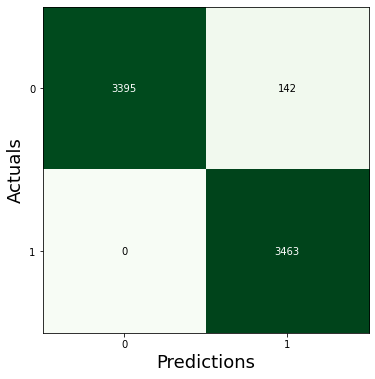

accuracy:97.971%


In [6]:
from model import plot_cm_matrix
plot_cm_matrix(model,batch,labels,save_url='graph/metric/SoftmaxTrainAcc.png')

### test accuracy

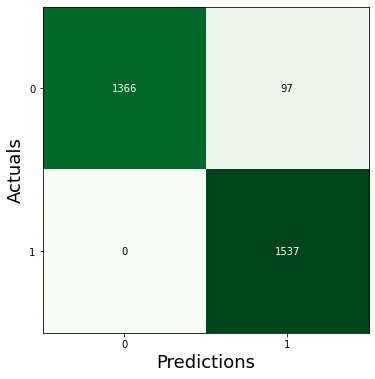

accuracy:96.767%


In [7]:
test_batch = Variable(torch.LongTensor(X_test))
test_labels = Variable(torch.LongTensor(y_test))
plot_cm_matrix(model,test_batch,test_labels,save_url='graph/metric/picture3.png')

### Save Model

In [ ]:
## 保存
torch.save(model.state_dict(), 'model/SoftmaxParameter.pkl')
torch.save(model, 'model/SoftmaxModel.pkl')

## 加载
#model = SelfAttnClassifier(vocab_size+1, 30, 10, 1, scale=5.0,score_function='dot',activation='SoftMax')
#model.load_state_dict(torch.load('model/SoftmaxParameter.pkl'))

# 加载
#model = torch.load('model/SoftmaxModel.pkl')

### Visualization

In [8]:
from model import compute_coefficients
pos_index,pos_score,pos_weight,neg_index,neg_score,neg_weight,neutral_index,neutral_score,neutral_weight = compute_coefficients(model,batch,Pos,Neg,Neu)

Pos Mean: 4.073960517682135 Pos Std: 3.2645322508932697
Neg Mean: 7.756971017122269 Neg Std: 5.317276408184461
Neu Mean: -5.987792274687025 Neu Std: 1.7667820722082246


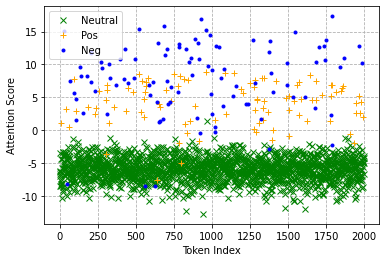

In [9]:
plt.rcParams['axes.unicode_minus'] = False
plt.plot(neutral_index, neutral_score, 'x', label='Neutral',color='green')
plt.plot(pos_index, pos_score, '+',label='Pos',color='orange')
plt.plot(neg_index, neg_score, '.', label='Neg',color='blue')
plt.xlabel('Token Index')
plt.ylabel('Attention Score')
plt.grid(linestyle='--')
plt.legend()
plt.savefig('graph/metric/picture1.png')
print('Pos Mean:',np.mean(pos_score),'Pos Std:',np.std(pos_score))
print('Neg Mean:',np.mean(neg_score),'Neg Std:',np.std(neg_score))
print('Neu Mean:',np.mean(neutral_score),'Neu Std:',np.std(neutral_score))

Pos Mean: 0.4867209152464629 Pos Std: 0.27745830981836933
Neg Mean: 0.4810178235792805 Neg Std: 0.2906122849785673
Neu Mean: 0.0001936942949612863 Neu Std: 0.001776710855956079


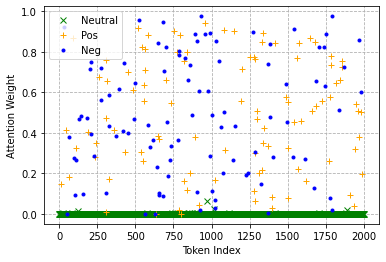

In [10]:
plt.rcParams['axes.unicode_minus'] = False
plt.plot(neutral_index, neutral_weight, 'x', label='Neutral',color='green')
plt.plot(pos_index, pos_weight, '+',label='Pos',color='orange')
plt.plot(neg_index, neg_weight, '.', label='Neg',color='blue')
plt.xlabel('Token Index')
plt.ylabel('Attention Weight')
plt.grid(linestyle='--')
plt.legend()
plt.savefig('graph/metric/picture2.png')
print('Pos Mean:',np.mean(pos_weight),'Pos Std:',np.std(pos_weight))
print('Neg Mean:',np.mean(neg_weight),'Neg Std:',np.std(neg_weight))
print('Neu Mean:',np.mean(neutral_weight),'Neu Std:',np.std(neutral_weight))

### Exp1--Feature Importance

3000it [00:05, 563.86it/s]


Both label
	p-value < 0.05: 518  ratio: 0.17266666666666666
	p-value < 0.01: 177  ratio: 0.059
	Both-Mean: -0.17048561076857613 Std: 0.25966329749456424

Pos
	p-value < 0.05: 448  ratio: 0.291476903057905
	p-value < 0.01: 166  ratio: 0.10800260247234873
	Pos-Mean: -0.3112566028636295 Std: 0.20967545249477812

Neg
	p-value < 0.05: 70  ratio: 0.04784688995215311
	p-value < 0.01: 11  ratio: 0.007518796992481203
	Neg-Mean: -0.022594281411025218 Std: 0.2222212835440696


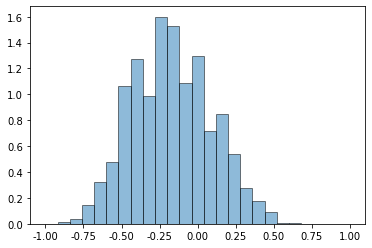

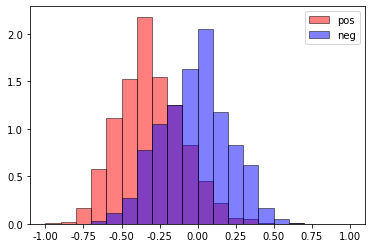

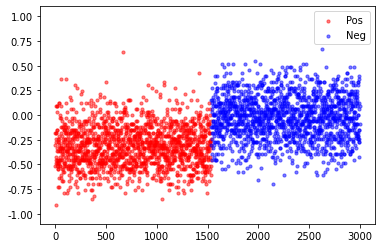

In [11]:
from model import GradientImportance
GradientImportance(model,test_batch,test_labels,'Softmax')

### Exp2--Feature Erasure

3000it [00:17, 173.17it/s]


Both label
	p-value < 0.05: 873  ratio: 0.291
	p-value < 0.01: 381  ratio: 0.127
	total num: 3000  mean: -0.3009212984212393  std: 0.2278988145461091
Pos
	p-value < 0.05: 430  ratio: 0.2797657774886142
	p-value < 0.01: 176  ratio: 0.11450878334417697
	total num: 1537  mean: -0.3031468430167953  std: 0.21682212411525237
Neg
	p-value < 0.05: 443  ratio: 0.3028024606971975
	p-value < 0.01: 205  ratio: 0.14012303485987695
	total num: 1463  mean: -0.29858318355905933  std: 0.23896108323822166


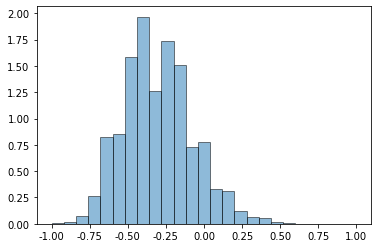

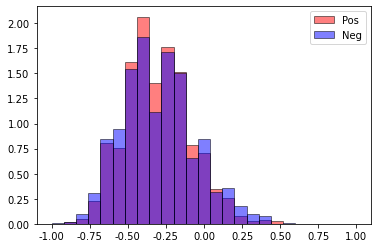

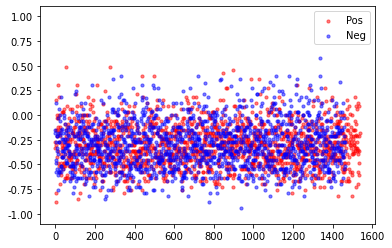

In [12]:
from model import FeatureErasure
FeatureErasure(model,test_batch,test_labels,'Softmax')

### Exp3--Feature Erasure ABS

3000it [00:17, 167.15it/s]


Both label
	p-value < 0.05: 513  ratio: 0.171
	p-value < 0.01: 200  ratio: 0.06666666666666667
	total num: 3000  mean: -0.1702040473731407  std: 0.26428055734345496
Pos
	p-value < 0.05: 445  ratio: 0.28952504879635654
	p-value < 0.01: 179  ratio: 0.11646063760572543
	total num: 1537  mean: -0.31317151797315534  std: 0.21236900008218781
Neg
	p-value < 0.05: 68  ratio: 0.04647983595352016
	p-value < 0.01: 21  ratio: 0.014354066985645933
	total num: 1463  mean: -0.020005139435873107  std: 0.22760958001814868


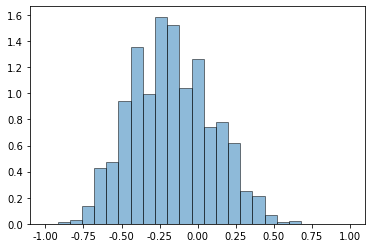

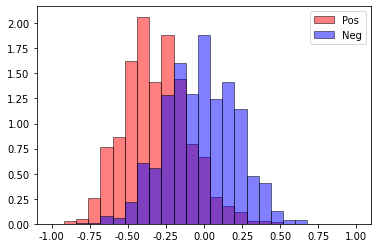

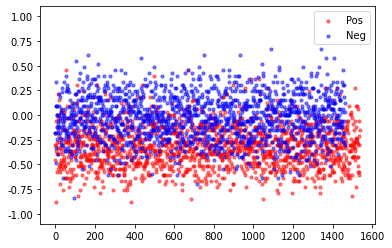

In [13]:
from model import FeatureErasureABS
FeatureErasureABS(model,test_batch,test_labels,'Softmax')

### Exp4--Attention Permutation

3000it [02:30, 19.87it/s]


Both label
	total num: 3000  mean: 0.024862166  std: 0.04123529
Pos
	total num: 1537  mean: 0.0009441635  std: 0.0009841048
Neg
	total num: 1463  mean: 0.049989972  std: 0.047468655


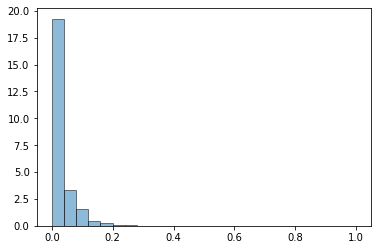

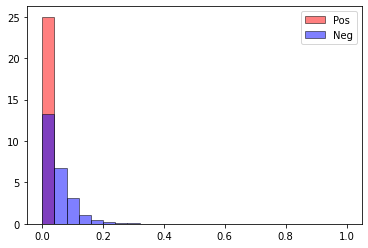

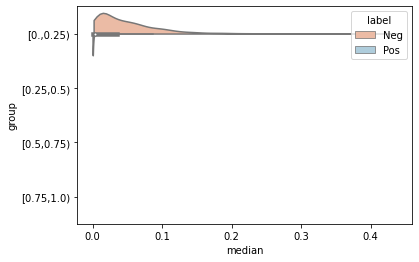

                 median                                                    \
                  count      mean       std       min       25%       50%   
label group                                                                 
Neg   [0.,0.25)  1463.0  0.049990  0.047485  0.001568  0.014400  0.036604   
Pos   [0.,0.25)  1537.0  0.000944  0.000984  0.000037  0.000297  0.000605   

                                     
                      75%       max  
label group                          
Neg   [0.,0.25)  0.069053  0.437643  
Pos   [0.,0.25)  0.001233  0.008717  


In [14]:
from model import AttnPermutation
AttnPermutation(model,test_batch,test_labels,'Softmax')

### Exp5--Attention Randomization

3000it [01:46, 28.30it/s]


Both label
	total num: 3000  mean: 0.093518466  std: 0.121834055
Pos
	total num: 1537  mean: 0.013044181  std: 0.011454898
Neg
	total num: 1463  mean: 0.17806323  std: 0.12786135


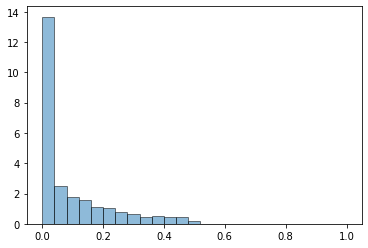

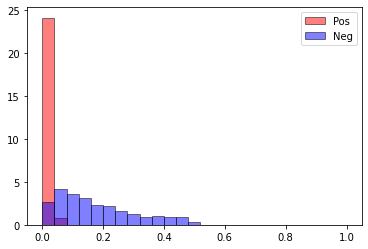

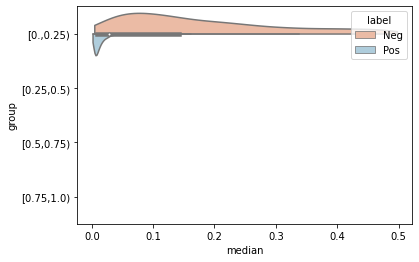

                 median                                                    \
                  count      mean       std       min       25%       50%   
label group                                                                 
Neg   [0.,0.25)  1463.0  0.178063  0.127905  0.004044  0.074677  0.144335   
Pos   [0.,0.25)  1537.0  0.013044  0.011459  0.001230  0.005718  0.009584   

                                     
                      75%       max  
label group                          
Neg   [0.,0.25)  0.256834  0.497340  
Pos   [0.,0.25)  0.016573  0.160933  


In [15]:
from model import AttnRandom
AttnRandom(model,test_batch,test_labels,'Softmax')